# Testing Space

This notebook allows for the user to test out various combinations of data preprocessing techniques and classification models. Within the notebook there are comments to highlight areas where customizations can be made.<br>

An example has already been set. In each step, at least 1 method must be kept for the model to function. Results are multiplicative, please limit the number of methods per step to avoid large computational time.<br>

In [68]:
# import the scripts folder
import sys
sys.path.append('../scripts')

In [78]:
from open_file import open_file
import data_preprocessing
import model_training
import evaluation
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

**CUSTOMIZATIONS can be made in this cell block**

In [84]:
##### Comment out modules that you do not want run 

# Define classify diagnosis (recommeneded to keep)
# Classification task changed from [no cancer, benign, malignant] to [no cancer = 0, cancer = 1]
classify_diagnosis = data_preprocessing.classify_diagnosis

###### Step 1. Define the missing value imputation methods and their descriptions
missing_value_functions = {
    #data_preprocessing.remove_missing: "Remove Missing Values",
    data_preprocessing.mean_missing: "Replace with Mean",
    #data_preprocessing.knn_missing: "Replace with KNN"
}

###### Step 2. Define the scaling/normalization methods and their descriptions
scaling_normalization_functions = {
    #data_preprocessing.min_max_scaler: "Min-Max Scaling",
    data_preprocessing.robust_scaler: "Robust Scaling",
    #data_preprocessing.quant_transformation: "Quantile Transformation",
    #data_preprocessing.log_transformation: "Log Transformation"
}

##### Step 3. Define the feature selection methods and their descriptions
feature_selection_functions = {
    data_preprocessing.rfe_feature: "Recursive Feature Elimination",
    #data_preprocessing.pca_feature: "Principal Component Analysis",
    #data_preprocessing.lasso_feature: "Lasso Regularizer",
}

##### Step 4. Define the data splitting methods and their descriptions
data_splitting_functions = {
    data_preprocessing.train_test_datasplit: "Train Test Split", 
    #data_preprocessing.repeated_k_fold_datasplit: "Repeated K Fold"
}

**CUSTOMIZATIONS can be made in this cell block**

In [85]:
##### Step 5. Define the model selection methods and their descriptions with hyperparameters

classifiers = {
#    "Logistic Regression": {
#        "model": LogisticRegression(),
#        "params": {
#            "C": [0.1, 1, 10],
#            "max_iter": [100, 200, 300]
#        }
#    },
#    "Random Forest": {
#        "model": RandomForestClassifier(),
#        "params": {
#            "n_estimators": [50, 100, 200],
#            "max_depth": [None, 5, 10]
#        }
#   },
    "Gradient Boosting Machine": {
       "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    },
#    "C-based Support Vector Classification": {
#        "model": SVC(),
#        "params": {
#            "C": [0.1, 1, 10],
#            "kernel": ["linear", "rbf"]
#        }
#    },
#    "K-Nearest Neighbour Classification": {
#        "model": KNeighborsClassifier(),
#        "params": {
#            "n_neighbors": [3, 5, 10],
#            "weights": ["uniform", "distance"]
#        }
#    }
}

In [86]:
# Step 6. Model Reporting
outcome_reporting = evaluation.outcome_reporting

In [87]:
# original data (mostly)
df = open_file()

# converting diagnosis to boolean (ignore if commented out above)
df['diagnosis'] = df['diagnosis'].apply(classify_diagnosis)

# seperating X and y
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

**CUSTOMIZATIONS can be made in this cell block**

Missing Value Imputation:
{'Robust Scaling'}
Scaling/Normalization: Recursive Feature Elimination
-
Feature Selection: Index(['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'], dtype='object'): Train Test Split
-
Data Split: Gradient Boosting Machine
-
Classification Model: {'model': GradientBoostingClassifier(), 'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}}
Best Parameters: Replace with Mean
Accuracy: 0.9152542372881356
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        80
           1       0.89      0.84      0.86        38

    accuracy                           0.92       118
   macro avg       0.91      0.90      0.90       118
weighted avg       0.91      0.92      0.91       118

[[76  4]
 [ 6 32]]


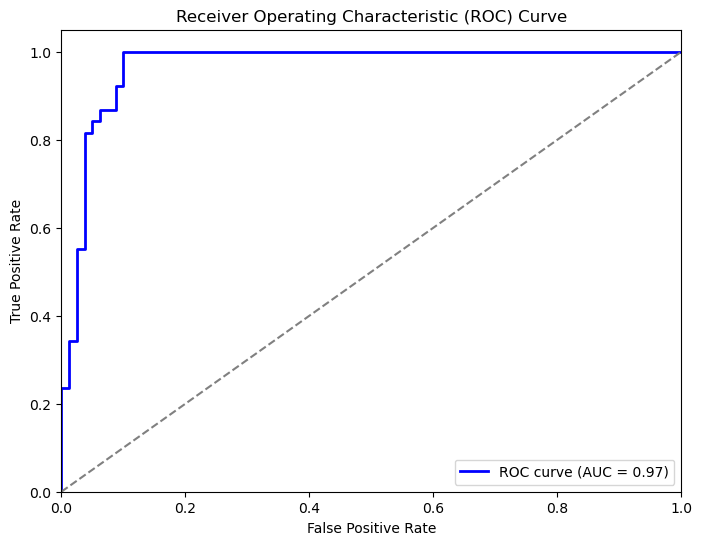


--------------------------------------------------



In [88]:
##### paramters can be set here
from sklearn.model_selection import GridSearchCV

# missing data handling
for missing_func, missing_desc in missing_value_functions.items():
    X_imputed_df = missing_func(X).drop(['diagnosis'], axis=1)
    
    # ----------------------    
    # scaling / normalization
    for scaling_func, scaling_desc in scaling_normalization_functions.items():
        X_transformed_data = scaling_func(X_imputed_df)
        X_transformed_df = pd.DataFrame(X_transformed_data, columns=X_imputed_df.columns)
        
        # ---------------------- 
        # feature selection
        for feature_func, feature_desc in feature_selection_functions.items():
            
            # Check if using Lasso
            if feature_func == data_preprocessing.lasso_feature:  
                ##### alpha can be set. default is 0.01
                selected_features = feature_func(X_transformed_df, y, alpha=0.01)  
            
            # Check if using PCA
            elif feature_func == data_preprocessing.pca_feature: 
                ##### n_components can be set. default is 3
                pca = feature_func(X_transformed_df, n_components=3)
                X_pca_transformed = pca.transform(X_transformed_df)
                selected_features = X_transformed_df.columns  
            
            # Else using RFE
            else:
                ##### n_features_to_select can be set. default is 5
                selected_features = feature_func(X_transformed_df, y, n_features_to_select=6)  
            
            # ---------------------- 
            # data splitting
            splits = None
            for split_func, split_desc in data_splitting_functions.items():
                
                # Check if using Train Test Split
                if split_func == data_preprocessing.train_test_datasplit:
                    ##### test_size can be set. default is 0.2
                    X_train, X_test, y_train, y_test = split_func(X_transformed_df[selected_features], y, test_size = 0.2)

                # Else using Repeated K Fold
                # n_splits = 5, n_repeats = 2
                else: 
                    splits = list(split_func(X_transformed_df[selected_features], y))
                    
                for model_name, model_desc in classifiers.items():
                    classifier = model_desc["model"]
                    params = model_desc["params"]

                    clf = GridSearchCV(classifier, params, cv=5, scoring='accuracy')
                    clf.fit(X_train, y_train)

                    outcome_reporting(X_test, y_test, clf, missing_desc, scaling_desc, feature_desc, selected_features, split_desc, model_name, model_desc)

# Check
* All missing value handlers work
* All scalling methods work
* All feature selection methods work
* All data splitting methods work
* All classifier models work (except for SVC)
    * in testing SVC models were not too effective